In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Reactions to offers

First let's see how each customer has reacted to each offer.

I will collect customer actions from transcript data and see if a customer saw an offer and completed it. If the offer was not viewed, was viewed but not completed or viewed and completed outside the time frame I reckon the customer was not effected by the offer.

In [2]:
# Collecting offer events from transcript
offer_events = transcript[(transcript['event']=='offer received') 
                          | (transcript['event']=='offer viewed')
                          | (transcript['event']=='offer completed')]

In [3]:
offer_events.tail()

,event,person,time,value
306497,offer completed,a6f84f4e976f44508c358cc9aba6d2b3,714,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
306506,offer completed,b895c57e8cd047a8872ce02aa54759d6,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306507,offer viewed,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
306509,offer completed,8431c16f8e1d440880db371a68f82dd0,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...


In [4]:
# open the value field to separate columns (this takes a while)
offer_events_opened = pd.concat([offer_events.drop(['value'], axis=1), offer_events['value'].apply(pd.Series)], axis=1)

In [5]:
offer_events = offer_events_opened.copy()

In [6]:
offer_events.head()

,event,person,time,offer id,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [7]:
# It seems there are offer ids in two columns, 'offer id' and 'offer_id'. 
# Combining those.

def combine_offer_id_cols(data):
    data['offer id'] = data['offer id'].fillna(data['offer_id'])
    data.drop(['offer_id'], inplace=True, axis=1)
    return data

combine_offer_id_cols(offer_events)

offer_events.head()

,event,person,time,offer id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Since one customer can get one specific offer more than once and I want to view reactions to all of them I need to keep on track how many times an offer is received. That's why I am adding a cumulative counter based on person id, offer id and event (received/viewed/completed). For example when a customer receives a specific offer the first time the count is 0, the second time 1 and so on. In that way I can combine the rows based on offer id later without losing any rows.

In [8]:
offer_events = offer_events.sort_values(by=['time'])

In [9]:
offer_events['offer_count'] = offer_events.groupby(['person', 'offer id', 'event']).cumcount()

In [10]:
# Here is an example of the actions and counts of one person

example_person_actions = offer_events[offer_events['person'] == '389bc3fa690240e798340f5a15918d5c']
example_person_actions[['offer id', 'event', 'time', 'offer_count']].sort_values(by=['time'])

,offer id,event,time,offer_count
12650,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,0,0
5,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0,0
32626,f19421c1d4aa40978ebb69ca19b0e20d,offer completed,60,0
53179,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,168,0
77212,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,192,0
110831,2906b810c7d4411798c6938adc9daaa5,offer received,336,0
132803,2906b810c7d4411798c6938adc9daaa5,offer viewed,354,0
150601,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,408,1
179953,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,438,1
200086,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,498,0


To understand if a customer was really effected by an offer we need to check if it was read before completion and completed within the offer time frame.

I am adding the duration of the offer (days) to each row and also the time (hours since starting of the test) when action happened.

In [11]:
# Collect offer duration from portfolio 
offers = portfolio.copy()

offer_events['offer_duration'] = offer_events['offer id'].map(offers.set_index('id')['duration'])

offer_events.head()

,event,person,time,offer id,reward,offer_count,offer_duration
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,7
9945,offer received,8a46d8fc3d2a48e89e37352ac5e96e65,0,5a8bc65990b245e5a138643cd4eb9837,NaN,0,3
9946,offer received,a947b467a2ee45129169d48dc397e442,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,7
9947,offer received,3a3aa6529e4d4567bce67cfe80f93e5e,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,7
9948,offer received,74f9d4f1f1814709a8ea99f1d231596d,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,10


In [12]:
# Moving events column values to separate columns (one-hot-encoding)
# so that we can see which action was made to set the time stamp to correct column

offer_events = pd.concat([offer_events, 
                    pd.get_dummies(offer_events['event'], 
                    prefix=None)], 
                    axis=1)
offer_events.drop(['event'], axis=1, inplace=True)

In [13]:
# Adding times to correct columns

offer_events.loc[offer_events['offer received'] == 1, 'received time'] = offer_events['time']
offer_events.loc[offer_events['offer viewed'] == 1, 'viewed time'] = offer_events['time']
offer_events.loc[offer_events['offer completed'] == 1, 'completion time'] = offer_events['time']

In [14]:
offer_events.tail()

,person,time,offer id,reward,offer_count,offer_duration,offer completed,offer received,offer viewed,received time,viewed time,completion time
305798,39200c5f788949ea9293c4bdbfd89767,714,2906b810c7d4411798c6938adc9daaa5,NaN,0,7,0,0,1,NaN,714.0,NaN
305801,8d501b5bda454c188e837579f8a1c50d,714,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,0,7,1,0,0,NaN,NaN,714.0
305807,6d93d0f88895420d8dfdca9ff5390bce,714,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,10,1,0,0,NaN,NaN,714.0
305772,61a90cab1e9a48e79734e2ec652c65a0,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,1,10,1,0,0,NaN,NaN,714.0
306527,24f56b5e1849462093931b164eb803b5,714,fafdcd668e3743c1bb461111dcafc2a4,2.0,0,10,1,0,0,NaN,NaN,714.0


Now that all the data is correctly edited we can group the rows by person, offer id and offer count so that each offer sent to each customer will be one row only.

In [15]:
aggregation_functions = {
    'offer received': 'sum', 
    'offer viewed': 'sum',
    'offer completed': 'sum', 
    'reward': 'sum',
    'offer_duration': 'first',
    'received time': 'first',
    'viewed time': 'first',
    'completion time': 'first'}

offer_events = offer_events.groupby(['person','offer id','offer_count']).aggregate(aggregation_functions)

In [16]:
offer_events.tail(8)

offer received  \
person                           offer id                         offer_count                   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0                         1   
                                                                  1                         1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7 0                         1   
                                 2906b810c7d4411798c6938adc9daaa5 0                         1   
                                                                  1                         1   
                                                                  2                         1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0                         1   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                         1   

                                                                               offer viewed  \
person                           offer id                         offer_count                 
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0                       1   
                                                                  1                       1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7 0                       1   
                                 2906b810c7d4411798c6938adc9daaa5 0                       1   
                                                                  1                       1   
                                                                  2                       1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0                       1   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                       1   

                                                                               offer completed  \
person                           offer id                         offer_count                    
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0                          1   
                                                                  1                          1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7 0                          1   
                                 2906b810c7d4411798c6938adc9daaa5 0                          1   
                                                                  1                          1   
                                                                  2                          1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0                          1   
                                 fafdcd668e3743c1bb461111dcafc2a4 0                          1   

                                                                               reward  \
person                           offer id                         offer_count           
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0               5.0   
                                                                  1               5.0   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7 0               5.0   
                                 2906b810c7d4411798c6938adc9daaa5 0               2.0   
                                                                  1               2.0   
                                                                  2               2.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 0               5.0   
                                 fafdcd668e3743c1bb461111dcafc2a4 0               2.0   

                                                                               offer_duration  \
person                           offer id                         offer_count                   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d 0                        

In [17]:
# To make it easier to handle resetting indexes. 
# Currently those are a combination of three columns and it makes it hard to handle.

offer_events = offer_events.reset_index()

Now we will check how each customer responded to each offer. Depending on the customer actions let's separate the offer rows by customer reaction.

- Effected: customer viewed and completed the offer in time - marketing was successful
- Churn: customer did not view or complete the offer
- Disinterested: customer saw the offer but did not complete - the offer was not interested enough
- Active: customer did not saw the offer but completed it anyway or saw it and completed it outside the time frame - an active customer, marketing not really needed

In [18]:
conditions = [
    (offer_events['viewed time'].isnull()) & (offer_events['completion time'].isnull()),
    (offer_events['viewed time'].notnull()) & (offer_events['completion time'].isnull()),
    ((offer_events['completion time']-offer_events['received time'])/24 < offer_events['offer_duration']),
    (offer_events['completion time'].notnull())]

choices = ['churn', 'disinterested', 'effected', 'active']

offer_events['status'] = np.select(conditions, choices, default='None')
offer_events.head()

,person,offer id,offer_count,offer received,offer viewed,offer completed,reward,offer_duration,received time,viewed time,completion time,status
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,2.0,7,576.0,NaN,576.0,effected
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0.0,4,336.0,372.0,NaN,disinterested
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0.0,3,168.0,192.0,NaN,disinterested
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,1,5.0,5,408.0,456.0,414.0,effected
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,1,1,1,2.0,10,504.0,540.0,528.0,effected


However, when checking the current table we can see all the informational offers are either disinterested or churn. That's because there is nothing to complete. Instead, we need to check if customers have made transactions durin the offer duration   (the time frame the customer is feeling the influence of the offer).

In [29]:
# IDs 3f207df678b143eea3cee63160fa8bed and 5a8bc65990b245e5a138643cd4eb9837 are the infromational offers
completed_informational = len(offer_events[
    ((offer_events['offer id']=='3f207df678b143eea3cee63160fa8bed') 
    | (offer_events['offer id']=='5a8bc65990b245e5a138643cd4eb9837'))
             & (offer_events['status']!='churn')
             & (offer_events['status']!='disinterested')])

print('The number of informational offers with status other than churn or disinterested: ', completed_informational)

The number of informational offers with status other than churn or disinterested:  0


In [30]:
# select informational offers only
transactions = transcript

#informational_offers = transcript[(transcript['offer id'].isin(
#    ['5a8bc65990b245e5a138643cd4eb9837', '3f207df678b143eea3cee63160fa8bed']))]
informational_offers.head()

KeyError: 'offer id'

In [31]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
# Here is an example of the offer statuses of one person

example_person_actions = offer_events[offer_events['person'] == '389bc3fa690240e798340f5a15918d5c']
example_person_actions[['offer id', 'offer_count', 'status']]

,offer id,offer_count,status
16634,2906b810c7d4411798c6938adc9daaa5,0,effected
16635,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,active
16636,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,disinterested
16637,f19421c1d4aa40978ebb69ca19b0e20d,0,effected
16638,f19421c1d4aa40978ebb69ca19b0e20d,1,effected
16639,fafdcd668e3743c1bb461111dcafc2a4,0,effected


The previous one was mostly to be able to analyze the data nicely, but for a machine learning model predicting if an offer is effective we just need a number defining if that was the case or not.

All the effected rows will have a value 1 = true (effective) and rest of them value 0 = false (no effect).

In [23]:
offer_events['success'] = 0
offer_events.loc[offer_events['status'] == 'effected', 'success'] = 1
offer_events[255:260]

Final step! We can remove the columns we do not need.

In [22]:
customers_and_offers = offer_events[['person', 'offer id', 'reward', 'offer_duration', 'status', 'success']].copy()
customers_and_offers.head()

### Person data

To get more data for the machine learning model let's add person details to our data table.

In [177]:
customers = profile.copy()

In [178]:
customers.rename(columns={'id':'person'}, inplace=True)
customers.set_index('person', inplace=True)
customers.head()

,age,became_member_on,gender,income
person,,,,
68be06ca386d4c31939f3a4f0e3dd783,118,20170212,None,NaN
0610b486422d4921ae7d2bf64640c50b,55,20170715,F,112000.0
38fe809add3b4fcf9315a9694bb96ff5,118,20180712,None,NaN
78afa995795e4d85b5d9ceeca43f5fef,75,20170509,F,100000.0
a03223e636434f42ac4c3df47e8bac43,118,20170804,None,NaN


In [179]:
# Since we do not really care about exact date let's change the became member on date to year only.

def set_member_year(data):
    data.became_member_on = data.became_member_on.fillna('19000101')
    data['became_member_on'] = data.became_member_on.apply(lambda x: str(x)[0:4])
    return data

customers = set_member_year(customers)

In [180]:
customers_and_offers['age'] = customers_and_offers['person'].map(customers['age'])
customers_and_offers['member_since'] = customers_and_offers['person'].map(customers['became_member_on'])
customers_and_offers['gender'] = customers_and_offers['person'].map(customers['gender'])
customers_and_offers['income'] = customers_and_offers['person'].map(customers['income'])

In [181]:
customers_and_offers.head()

,person,offer id,reward,offer_duration,status,success,age,member_since,gender,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,7,effected,1,33,2017,M,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,4,disinterested,0,33,2017,M,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,3,disinterested,0,33,2017,M,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5,effected,1,33,2017,M,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,10,effected,1,33,2017,M,72000.0


Also, let's collect all offer information from portfolio

In [182]:
offers = portfolio.copy()
offers # all ten of them

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [183]:
# Separate channels to own columns
channels = offers.channels.apply(pd.Series).stack().value_counts().index
for i in channels:
    offers[i] = offers.channels.apply(lambda x: i in x).map({ True: 1, False: 0 })

# Drop original channels column
offers.drop(columns=['channels'], inplace=True)
    
offers.head()

,difficulty,duration,id,offer_type,reward,email,mobile,web,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0


In [184]:
customers_and_offers['difficulty'] = customers_and_offers['offer id'].map(offers.set_index('id')['difficulty'])
customers_and_offers['offer_type'] = customers_and_offers['offer id'].map(offers.set_index('id')['offer_type'])
customers_and_offers['email'] = customers_and_offers['offer id'].map(offers.set_index('id')['email'])
customers_and_offers['mobile'] = customers_and_offers['offer id'].map(offers.set_index('id')['mobile'])
customers_and_offers['web'] = customers_and_offers['offer id'].map(offers.set_index('id')['web'])
customers_and_offers['social'] = customers_and_offers['offer id'].map(offers.set_index('id')['social'])

In [185]:
customers_and_offers.head(10)

,person,offer id,reward,offer_duration,status,success,age,member_since,gender,income,difficulty,offer_type,email,mobile,web,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,7,effected,1,33,2017,M,72000.0,10,discount,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,4,disinterested,0,33,2017,M,72000.0,0,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,3,disinterested,0,33,2017,M,72000.0,0,informational,1,1,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5,effected,1,33,2017,M,72000.0,5,bogo,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,10,effected,1,33,2017,M,72000.0,10,discount,1,1,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5,disinterested,0,118,2018,None,NaN,5,bogo,1,1,1,1
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5,disinterested,0,118,2018,None,NaN,5,bogo,1,1,1,1
7,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,10,effected,1,40,2018,O,57000.0,20,discount,1,0,1,0
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7,effected,1,40,2018,O,57000.0,7,discount,1,1,1,1
9,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,4,disinterested,0,40,2018,O,57000.0,0,informational,1,1,1,0


To add one more detail of each person let's collect how much they have spent on Starbucks during the test period.

In [187]:
# Collecting transactions from transcript
transactions = transcript[transcript['event']=='transaction']

# Opening value field to get amount spent to an own column
transactions_opened = pd.concat([transactions.drop(['value'], axis=1), transactions['value'].apply(pd.Series)], axis=1)

# Amount sum per customer
aggregation_functions = {'amount': 'sum'}
transactions_per_customer = transactions_opened.groupby(transactions_opened['person']).aggregate(aggregation_functions)

In [188]:
transactions_per_customer.head()

,amount
person,
0009655768c64bdeb2e877511632db8f,127.60
00116118485d4dfda04fdbaba9a87b5c,4.09
0011e0d4e6b944f998e987f904e8c1e5,79.46
0020c2b971eb4e9188eac86d93036a77,196.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05


In [189]:
# Combine to the main data frame
customers_and_offers['spent'] = offer_events['person'].map(transactions_per_customer['amount'])

In [190]:
customers_and_offers.head(10)

,person,offer id,reward,offer_duration,status,success,age,member_since,gender,income,difficulty,offer_type,email,mobile,web,social,spent
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,7,effected,1,33,2017,M,72000.0,10,discount,1,1,1,0,127.60
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,4,disinterested,0,33,2017,M,72000.0,0,informational,1,1,1,0,127.60
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,3,disinterested,0,33,2017,M,72000.0,0,informational,1,1,0,1,127.60
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5,effected,1,33,2017,M,72000.0,5,bogo,1,1,1,1,127.60
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,10,effected,1,33,2017,M,72000.0,10,discount,1,1,1,1,127.60
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5,disinterested,0,118,2018,None,NaN,5,bogo,1,1,1,1,4.09
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5,disinterested,0,118,2018,None,NaN,5,bogo,1,1,1,1,4.09
7,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,10,effected,1,40,2018,O,57000.0,20,discount,1,0,1,0,79.46
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7,effected,1,40,2018,O,57000.0,7,discount,1,1,1,1,79.46
9,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,4,disinterested,0,40,2018,O,57000.0,0,informational,1,1,1,0,79.46


### Final human readable table

Below is the data we start to process to make it machine readable.

In [199]:
#data = customers_and_offers[['person', 'age', 'gender', 'income', 'member_since', 'spent', 'offer id', 'offer_type', 'offer_duration', 'email', 'mobile', 'web', 'social', 'difficulty', 'reward', 'status', 'success']].sort_values(by=['offer id']).copy()
data = customers_and_offers[['person', 'age', 'gender', 'income', 'member_since', 'spent', 'offer id', 'offer_type', 'offer_duration', 'email', 'mobile', 'web', 'social', 'difficulty', 'reward', 'status', 'success']].copy()

In [200]:
#data.head()
data

,person,age,gender,income,member_since,spent,offer id,offer_type,offer_duration,email,mobile,web,social,difficulty,reward,status,success
0,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017,127.60,2906b810c7d4411798c6938adc9daaa5,discount,7,1,1,1,0,10,2.0,effected,1
1,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017,127.60,3f207df678b143eea3cee63160fa8bed,informational,4,1,1,1,0,0,0.0,disinterested,0
2,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017,127.60,5a8bc65990b245e5a138643cd4eb9837,informational,3,1,1,0,1,0,0.0,disinterested,0
3,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017,127.60,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,5,5.0,effected,1
4,0009655768c64bdeb2e877511632db8f,33,M,72000.0,2017,127.60,fafdcd668e3743c1bb461111dcafc2a4,discount,10,1,1,1,1,10,2.0,effected,1
5,00116118485d4dfda04fdbaba9a87b5c,118,None,NaN,2018,4.09,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,5,0.0,disinterested,0
6,00116118485d4dfda04fdbaba9a87b5c,118,None,NaN,2018,4.09,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,5,0.0,disinterested,0
7,0011e0d4e6b944f998e987f904e8c1e5,40,O,57000.0,2018,79.46,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,1,0,1,0,20,5.0,effected,1
8,0011e0d4e6b944f998e987f904e8c1e5,40,O,57000.0,2018,79.46,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,1,1,1,1,7,3.0,effected,1
9,0011e0d4e6b944f998e987f904e8c1e5,40,O,57000.0,2018,79.46,3f207df678b143eea3cee63160fa8bed,informational,4,1,1,1,0,0,0.0,disinterested,0


## Analyzing data

Since we did not check if a customer spent any money during the offer timeframe if an offer was informational, all of them are false success.

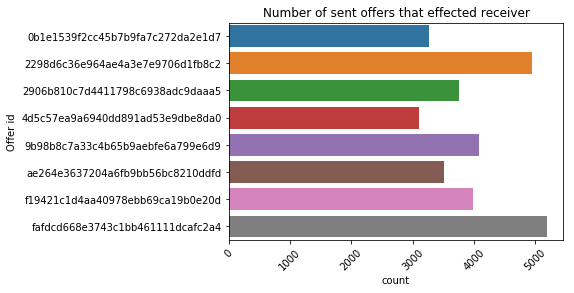

In [198]:
completed_count = data[data['success'] == 1]

sns.countplot(y=completed_count['offer id'])
plt.title('Number of sent offers that effected receiver')
plt.ylabel('Offer id')
plt.xticks(rotation = 45)
plt.show();

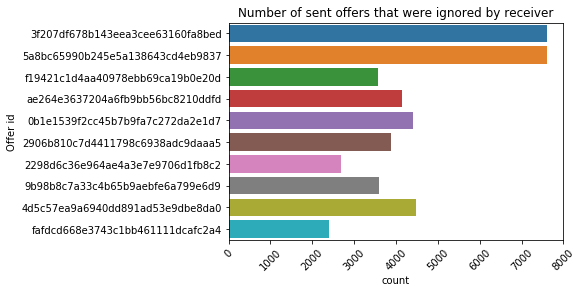

In [204]:
ignored_count = data[data['success'] == 0]

sns.countplot(y=ignored_count['offer id'])
plt.title('Number of sent offers that were ignored by receiver')
plt.ylabel('Offer id')
plt.xticks(rotation = 45)
plt.show();

In [ ]:
# Combine profile and portfolio
# group some values (f.ex. income)
# test and train sets
# throw to model (success is the label)

In [ ]:
# Update suggestions
# To see the probability if offer viewed
# How many transactions; how much spent; Min and max purchases; average purhcase
# if customer was churn did they change to effect / if cust was active would informative be enough
# Hmm why there are so big purchases? (185 rows of >500)